# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [5]:
from pathlib import Path
import os
import random
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt

import utils

# modify to where you store your project data including utils.py
datadir = Path("samples")

### Part I: Randomly Sampled Texture (10 pts)

In [ ]:
def quilt_random(sample: np.ndarray, out_size: int, patch_size: int) -> np.ndarray:
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image
    of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    # Initialize the target image
    sample_width, sample_height, color_depth = sample.shape
    target = np.zeros((out_size, out_size, color_depth), dtype=np.uint8)
    tiles = (out_size // patch_size) * patch_size

    for i in range(0, tiles, patch_size):
        for j in range(0, tiles, patch_size):
            patch_i = random.randrange(sample_width - patch_size)
            patch_j = random.randrange(sample_height - patch_size)
            patch = sample[
                patch_i : patch_i + patch_size, patch_j : patch_j + patch_size
            ]
            target[i : i + patch_size, j : j + patch_size] = patch

    return target

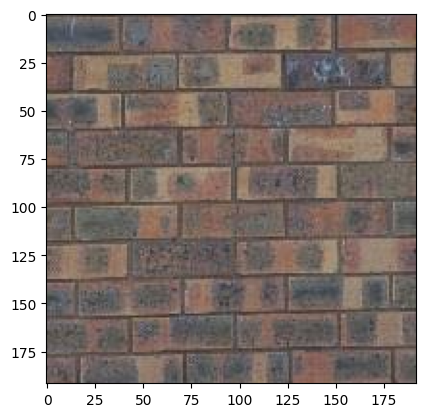

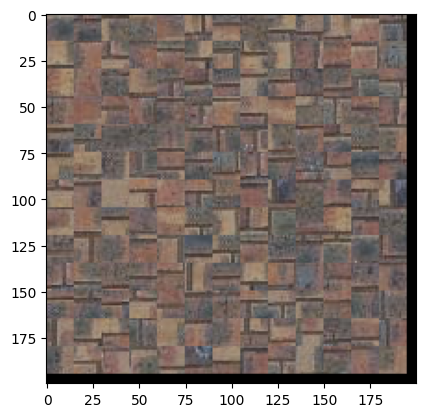

In [21]:
sample_img_fn = "samples/bricks_small.jpg"  # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15
result = quilt_random(sample_img, out_size, patch_size)
if result is not None:
    plt.imshow(result)

### Part II: Overlapping Patches (30 pts)

In [318]:
def ssd_patch(template: np.ndarray, mask: np.ndarray, sample: np.ndarray) -> np.ndarray:
    """
    ssd_patch performs template matching with the overlapping region, computing the cost of sampling
    each patch, based on the sum of squared differences (SSD) of the overlapping regions of the
    existing and sampled patch. I suggest using a masked template. The template is the patch in the
    current output image that is to be filled in (many pixel values will be 0 because they are not
    filled in yet). The mask has the same size as the patch template and has values of 1 in the
    overlapping region and values of 0 elsewhere. The SSD of the masked template with the input
    texture image can be computed efficiently using filtering operations. Suppose I have a template
    T, a mask M, and an image I: then, ssd_cost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1,
    kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M). You can compute SSD in this way for
    each channel and sum the costs over channels. Each pixel of the ssd_cost gives you the cost for
    sampling a patch centered around that pixel.
    """
    # Dims might be 2 when we use this for luminance
    if sample.ndim == 2:
        sample = sample[:, :, None]
    if template.ndim == 2:
        template = template[:, :, None]
    if mask.ndim == 2:
        mask = mask[:, :, None]
    sample_height, sample_width, sample_channels = sample.shape

    # Broadcast the mask across channels
    mask = np.repeat(mask.astype(np.float32), sample_channels, axis=2)
    template = template.astype(np.float32)
    sample = sample.astype(np.float32)

    # Accumulate SSD over channels
    ssd_image = np.zeros((sample_height, sample_width))

    for channel_index in range(sample_channels):
        template_channel = template[:, :, channel_index]
        sample_channel = sample[:, :, channel_index]
        mask_channel = mask[:, :, channel_index]

        # sum((M * T)^2)
        masked_template_channel = mask_channel * template_channel
        constant_term = np.sum(masked_template_channel**2)

        # Cross term and sample-squared term
        cross_term = cv2.filter2D(
            src=sample_channel,
            ddepth=-1,
            kernel=masked_template_channel,
            borderType=cv2.BORDER_REFLECT,
        )
        sample_squared_term = cv2.filter2D(
            src=sample_channel**2,
            ddepth=-1,
            kernel=mask_channel,
            borderType=cv2.BORDER_REFLECT,
        )

        ssd_image += sample_squared_term - 2.0 * cross_term + constant_term

    # Poison scores on the border to prevent them from ever being selected
    border_size = template.shape[0] // 2
    ssd_image[:border_size] = 1e9
    ssd_image[-border_size:] = 1e9
    ssd_image[:, :border_size] = 1e9
    ssd_image[:, -border_size:] = 1e9

    return ssd_image

In [319]:
def choose_sample(
    sample: np.ndarray, cost_image: np.ndarray, patch_size: int, tolerance: int
) -> np.ndarray:
    """
    choose_sample should take as input a cost image (each pixel's value is the cost of selecting the
    patch centered at that pixel) and select a randomly sampled patch with low cost. It's
    recommended to sort the costs and choose of the tol smallest costs. So if tol=1, the lowest
    cost will always be chosen (this is a good way to debug but mainly copies the input texture). If
    tol=3, one of the three lowest cost patches will be chosen.
    """
    half_patch = patch_size // 2
    # This gets a list of the (flat) indices of the smallest pixels
    top_indices = cost_image.ravel().argpartition(tolerance - 1)[:tolerance]

    flat_index = random.choice(top_indices)
    # Row major order, so convert the single number into y, x coordinates
    y, x = np.unravel_index(flat_index, cost_image.shape)
    y -= half_patch
    x -= half_patch
    y = max(0, min(y, sample.shape[0] - patch_size))
    x = max(0, min(x, sample.shape[1] - patch_size))

    return sample[y : y + patch_size, x : x + patch_size]

In [320]:
def quilt_simple(
    sample: np.ndarray, out_size: int, patch_size: int, overlap: int, tolerance: float
) -> np.ndarray:
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image
    of size outsize.

    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tolerance: float
    :return: numpy.ndarray
    """
    sample_height, sample_width, color_depth = sample.shape
    target = np.zeros((out_size, out_size, color_depth))

    # Convert the sample to float
    sample = sample.copy() / 255.0

    # Create our starter patch:
    patch_i = random.randrange(sample_height - patch_size)
    patch_j = random.randrange(sample_width - patch_size)
    patch = sample[patch_i : patch_i + patch_size, patch_j : patch_j + patch_size]
    target[0:patch_size, 0:patch_size] = patch

    step_size = patch_size - overlap
    tiles = ((out_size - patch_size) // step_size) * step_size

    for i in range(0, tiles, step_size):
        for j in range(0, tiles, step_size):
            if i + j == 0:
                # First row, first column, skip as this is our default
                continue

            template = target[i : i + patch_size, j : j + patch_size]
            mask = np.zeros((patch_size, patch_size, 1), dtype=bool)
            if j != 0:
                # Only apply after the first column
                mask[:, :overlap] = True
            if i != 0:
                # Only apply after the first row
                mask[:overlap] = True

            cost_image = ssd_patch(template=template, mask=mask, sample=sample)
            sample_patch = choose_sample(
                sample=sample,
                cost_image=cost_image,
                patch_size=patch_size,
                tolerance=tolerance,
            )

            # print(i, j, sample.shape)
            target[i : i + patch_size, j : j + patch_size] = sample_patch

    return (target * 255).astype(np.uint8)

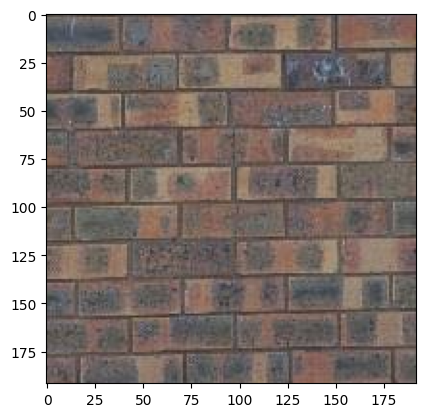

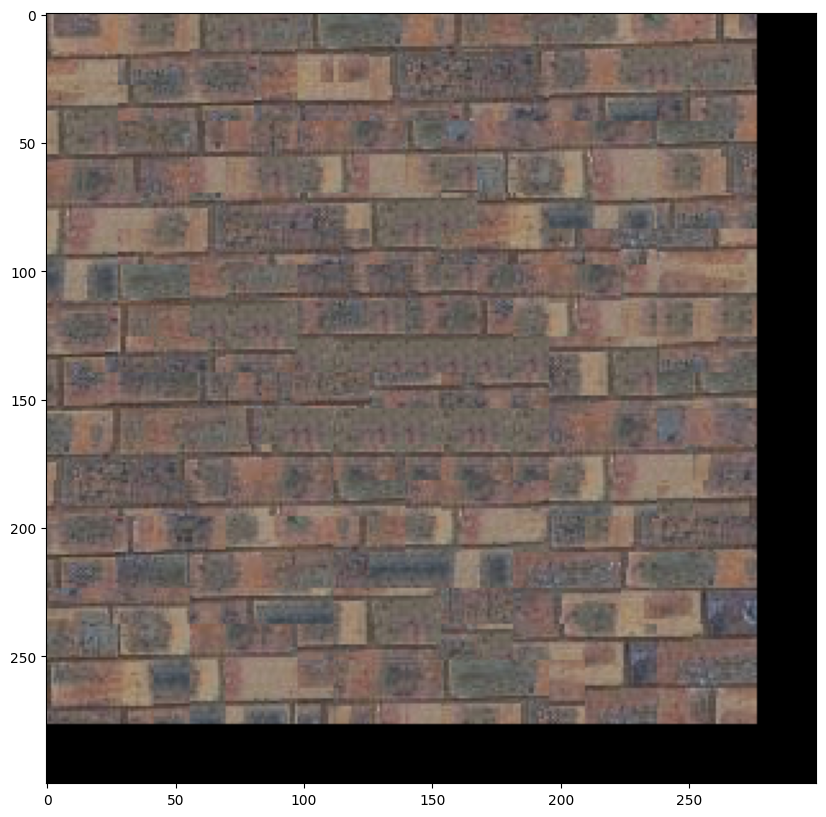

In [321]:
sample_img_fn = "samples/bricks_small.jpg"
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
result = quilt_simple(
    sample_img, out_size, patch_size, overlap, tol
)  # feel free to change parameters to get best results
if result is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(result)

### Part III: Seam Finding (20 pts)


In [322]:
# optional or use cut(err_patch) directly
def customized_cut(
    template: np.ndarray,
    sample_patch: np.ndarray,
    overlap: int,
    use_left_overlap: bool,
    use_top_overlap: bool,
    *,
    debug: bool = False
) -> np.ndarray:
    """
    Seam-cut the overlapping regions between `template` and `sample_patch`.

    For each overlap:
    - Computes an error surface e = (B1 - B2)^2 over the overlap (from SIGGRAPH paper)
    - Uses utils.cut to get the minimal path

    Combines the cut masks and returns the masked combination of template & sample_path

    Returns the blended patch to write into the target image.
    """
    if template.shape != sample_patch.shape:
        raise ValueError("template and sample_patch must have the same shape.")

    patch_height, patch_width, channel_count = sample_patch.shape
    composite_mask = np.ones((patch_height, patch_width), dtype=bool)

    if use_left_overlap:
        # Vertical overlap (left strip of the patch)
        vertical_error = np.sum(
            (template[:, :overlap, :] - sample_patch[:, :overlap, :]) ** 2, axis=2
        )
        # Transpose so we are still cutting left to right
        vertical_cut_overlap_mask = utils.cut(vertical_error.T).astype(bool).T

        # Place into full-size mask.
        composite_mask[:, :overlap] = vertical_cut_overlap_mask

    if use_top_overlap:
        # Horizontal overlap (top strip of the patch)
        horizontal_error = np.sum(
            (template[:overlap, :, :] - sample_patch[:overlap, :, :]) ** 2, axis=2
        )
        horizontal_cut_overlap_mask = utils.cut(horizontal_error).astype(bool)

        # Logical and to combine overlap masks
        composite_mask[:overlap, :] = (
            composite_mask[:overlap, :] & horizontal_cut_overlap_mask
        )

    # Blend using the composite mask
    blended_patch = np.where(composite_mask[..., None], sample_patch, template)

    if not debug:
        return blended_patch

    ## Debug code for displaying intermediate steps ##
    # Overlaps
    if use_left_overlap:
        plt.figure(figsize=(10, 3))
        plt.suptitle("Vertical overlap (left strip)")
        plt.subplot(1, 3, 1)
        plt.title("Template left overlap")
        plt.imshow(np.clip(template[:, :overlap, :], 0.0, 1.0))
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title("Sample left overlap")
        plt.imshow(np.clip(sample_patch[:, :overlap, :], 0.0, 1.0))
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title("Vertical error (SSD)")
        plt.imshow(vertical_error, cmap="magma")
        plt.axis("off")
        plt.show()

    if use_top_overlap:
        plt.figure(figsize=(10, 3))
        plt.suptitle("Horizontal overlap (top strip)")
        plt.subplot(1, 3, 1)
        plt.title("Template top overlap")
        plt.imshow(np.clip(template[:overlap, :, :], 0.0, 1.0))
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title("Sample top overlap")
        plt.imshow(np.clip(sample_patch[:overlap, :, :], 0.0, 1.0))
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title("Horizontal error (SSD)")
        plt.imshow(horizontal_error, cmap="magma")
        plt.axis("off")
        plt.show()

    # Masks
    plt.figure(figsize=(12, 3))
    plt.suptitle("Seam masks")
    plt.subplot(1, 3, 1)
    plt.title("Horizontal mask (top)")
    if horizontal_cut_overlap_mask is None:
        plt.imshow(np.zeros((max(1, overlap), patch_width), dtype=float), cmap="gray")
    else:
        plt.imshow(horizontal_cut_overlap_mask.astype(float), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Vertical mask (left)")
    if vertical_cut_overlap_mask is None:
        plt.imshow(np.zeros((patch_height, max(1, overlap)), dtype=float), cmap="gray")
    else:
        plt.imshow(vertical_cut_overlap_mask.astype(float), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Combination mask")
    plt.imshow(composite_mask.astype(float), cmap="gray")
    plt.axis("off")
    plt.show()

    return blended_patch

In [323]:
def quilt_cut(
    sample: np.ndarray, out_size: int, patch_size: int, overlap: int, tolerance: float
) -> np.ndarray:
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an
    output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    sample_height, sample_width, color_depth = sample.shape
    target = np.zeros((out_size, out_size, color_depth))

    # Convert the sample to float
    sample = sample.copy() / 255.0

    # Create our starter patch:
    patch_i = random.randrange(sample_height - patch_size)
    patch_j = random.randrange(sample_width - patch_size)
    patch = sample[patch_i : patch_i + patch_size, patch_j : patch_j + patch_size]
    target[0:patch_size, 0:patch_size] = patch

    step_size = patch_size - overlap
    tiles = ((out_size - patch_size) // step_size) * step_size

    for i in range(0, tiles, step_size):
        for j in range(0, tiles, step_size):
            if i + j == 0:
                # First row, first column, skip as this is our default
                continue

            template = target[i : i + patch_size, j : j + patch_size]
            mask = np.zeros((patch_size, patch_size, 1), dtype=bool)
            if j != 0:
                # Only apply after the first column
                mask[:, :overlap] = True
            if i != 0:
                # Only apply after the first row
                mask[:overlap] = True

            cost_image = ssd_patch(template=template, mask=mask, sample=sample)
            sample_patch = choose_sample(
                sample=sample,
                cost_image=cost_image,
                patch_size=patch_size,
                tolerance=tolerance,
            )

            # Cut and blend the samples
            blended_patch: np.ndarray = customized_cut(
                template=template,
                sample_patch=sample_patch,
                overlap=overlap,
                use_left_overlap=(j != 0),
                use_top_overlap=(i != 0),
            )

            # print(i, j, sample.shape)
            target[i : i + patch_size, j : j + patch_size] = blended_patch

    # For the very last patch, re-do the cutting with debug = True so we can see evidence of the cut
    blended_patch: np.ndarray = customized_cut(
        template=template,
        sample_patch=sample_patch,
        overlap=overlap,
        use_left_overlap=(j != 0),
        use_top_overlap=(i != 0),
        debug=True,
    )

    return (target * 255).astype(np.uint8)

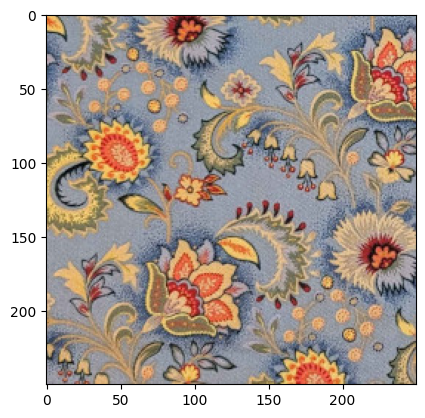

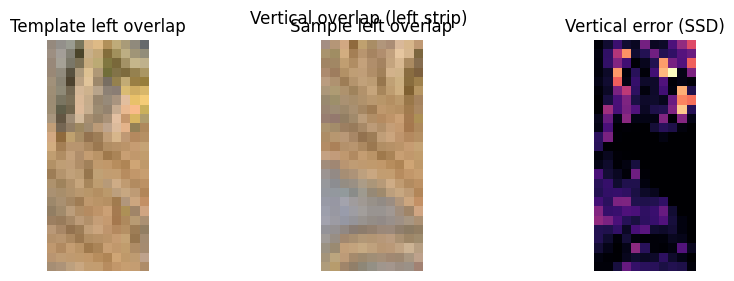

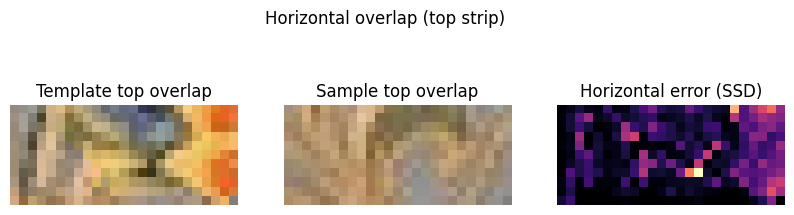

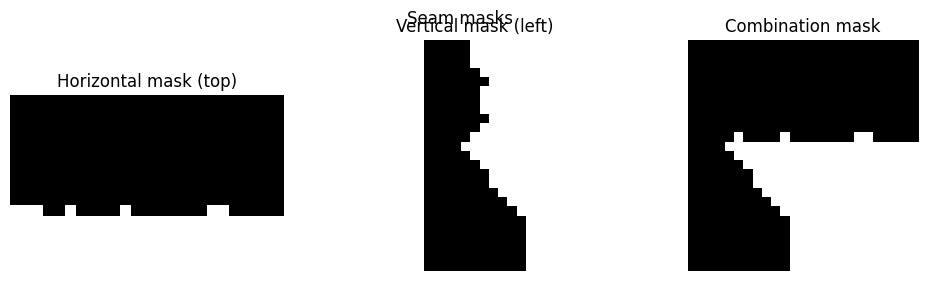

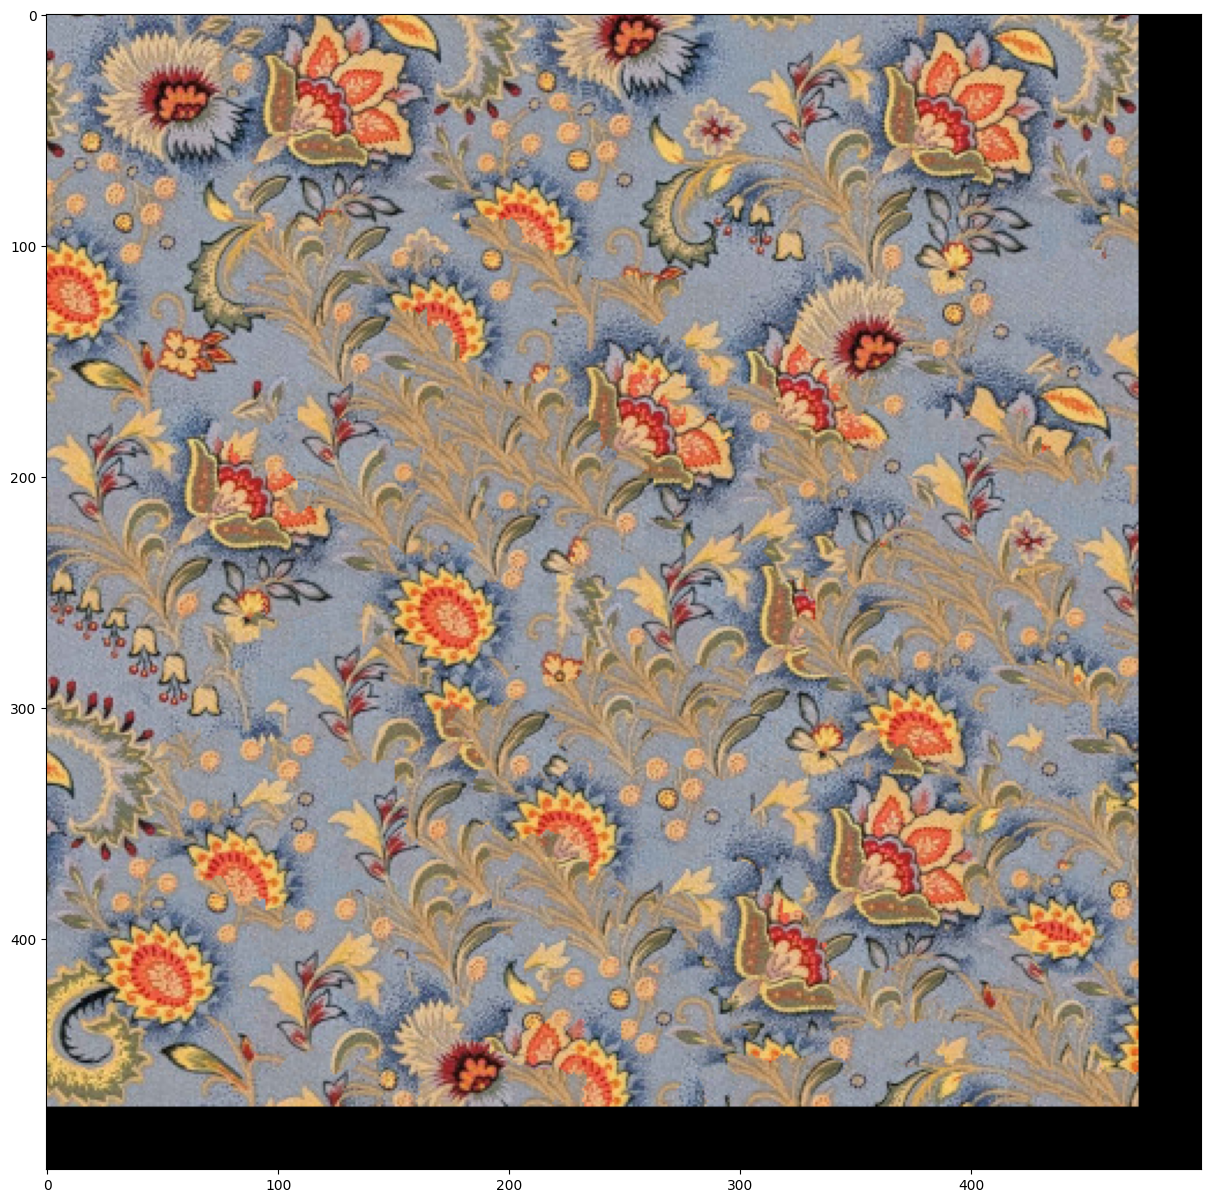

In [324]:
sample_img_fn = "samples/bricks_small.jpg"
sample_img_fn = "my_images/table_cloth_250.jpg"
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
result = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if result is not None:
    plt.figure(figsize=(15, 15))
    plt.imshow(result)

### part IV: Texture Transfer (30 pts)

In [ ]:
def texture_transfer(
    sample: np.ndarray,
    patch_size: int,
    overlap: int,
    tolerance: int,
    guidance_image: np.ndarray,
    alpha: float,
):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an
    output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tolerance: float
    :param guidance_image: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """

    # Luminance
    sample_hls = cv2.cvtColor(sample, cv2.COLOR_RGB2HLS)
    sample_luminance = sample_hls[:, :, 1]
    guidance_hls = cv2.cvtColor(guidance_image, cv2.COLOR_RGB2HLS)
    guidance_luminance = guidance_hls[:, :, 1]

    sample_luminance = sample_luminance / 255.0
    guidance_luminance = guidance_luminance / 255.0

    sample = sample.copy() / 255.0

    output_height, output_width = guidance_luminance.shape
    channel_count = sample.shape[2]
    target = np.zeros((output_height, output_width, channel_count), dtype=np.float32)

    step_size = patch_size - overlap
    last_row = output_height - patch_size
    last_col = output_width - patch_size

    for row in range(0, last_row + 1, step_size):
        for col in range(0, last_col + 1, step_size):
            template = target[row : row + patch_size, col : col + patch_size]

            # Build the overlap mask
            overlap_mask = np.zeros((patch_size, patch_size, 1), dtype=np.float32)
            if col != 0:
                overlap_mask[:, :overlap, 0] = 1.0
            if row != 0:
                overlap_mask[:overlap, :, 0] = 1.0

            # Overlap cost - same as texture synth, above
            if row == 0 and col == 0:
                overlap_cost = np.zeros(sample_luminance.shape, dtype=np.float32)
            else:
                overlap_cost = ssd_patch(
                    template=template,
                    mask=overlap_mask,
                    sample=sample,
                )

            # Guidance cost - SSD again, but between guidance window and sample luminance
            guidance_window = guidance_luminance[
                row : row + patch_size, col : col + patch_size
            ]
            ones_mask = np.ones((patch_size, patch_size, 1), dtype=np.float32)
            guidance_cost = ssd_patch(
                template=guidance_window,
                mask=ones_mask,
                sample=sample_luminance,
            )

            combined_cost = alpha * overlap_cost + (1.0 - alpha) * guidance_cost

            sample_patch = choose_sample(
                sample=sample,
                cost_image=combined_cost,
                patch_size=patch_size,
                tolerance=tolerance,
            )

            sample_patch = customized_cut(
                template=template,
                sample_patch=sample_patch,
                overlap=overlap,
                use_left_overlap=(col != 0),
                use_top_overlap=(row != 0),
                debug=False,
            )

            target[row : row + patch_size, col : col + patch_size] = sample_patch

    return (target * 255).astype(np.uint8)

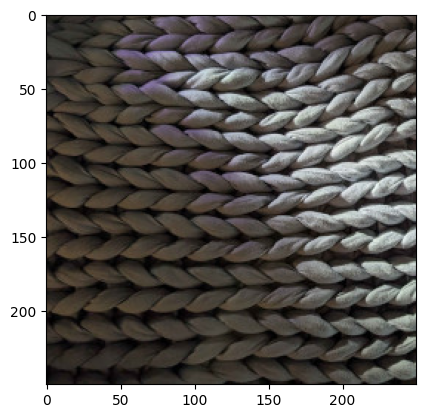

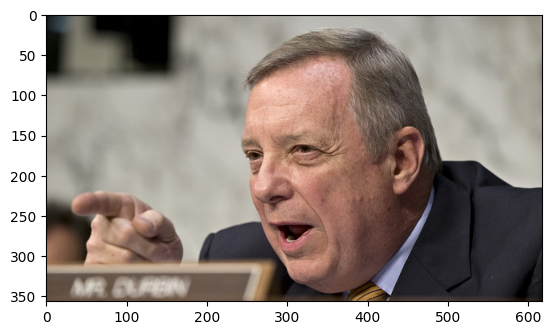

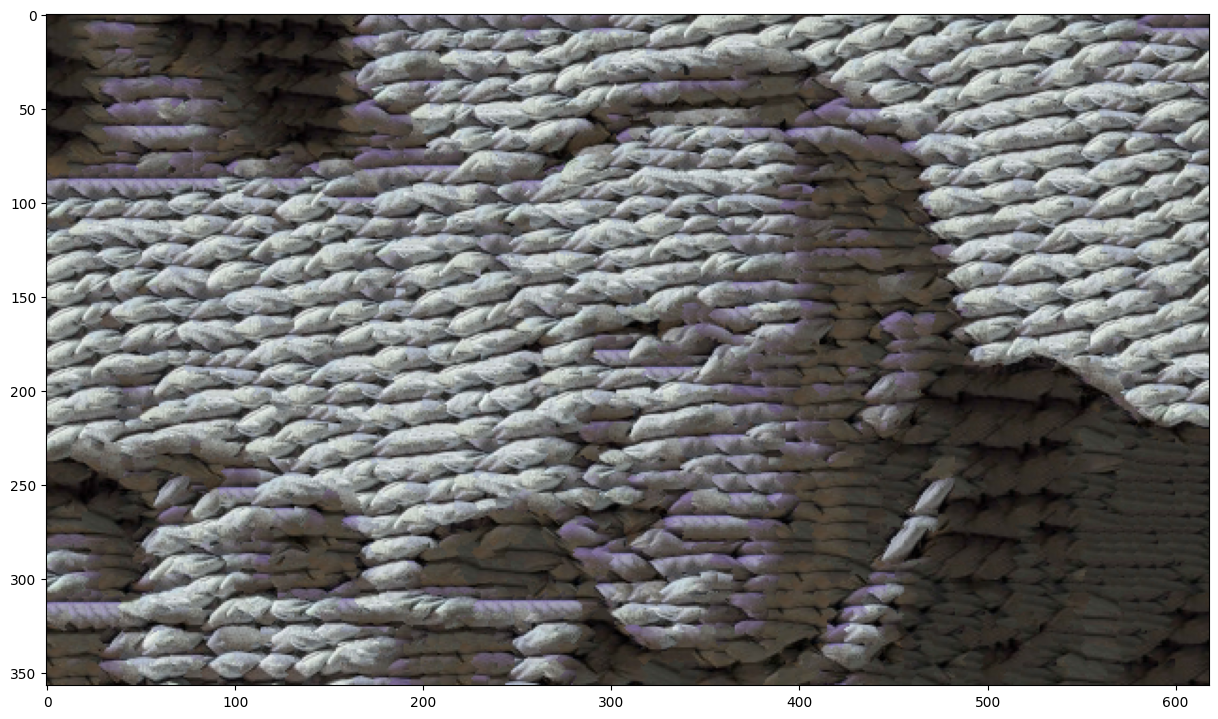

In [351]:
# load/process appropriate input texture and guidance images
texture_file = "my_images/blanket_250.jpg"
guidance_file = "my_images/illinois_senator_dick_durbin.jpg"
texture_image = cv2.cvtColor(cv2.imread(texture_file), cv2.COLOR_BGR2RGB)
guidance_image = cv2.cvtColor(cv2.imread(guidance_file), cv2.COLOR_BGR2RGB)

plt.imshow(texture_image)
plt.show()
plt.imshow(guidance_image)
plt.show()

patch_size = 15
overlap = 6
tol = 3
alpha = 0.5
result = texture_transfer(
    texture_image, patch_size, overlap, tol, guidance_image, alpha
)

plt.figure(figsize=(15, 15))
plt.imshow(result)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [ ]:
def texture_transfer_iterative(
    sample: np.ndarray,
    patch_size: int,
    overlap: int,
    tolerance: int,
    guidance_image: np.ndarray,
    num_iterations: int = 3,
) -> np.ndarray:
    """
    Iterative texture transfer via image quilting with a correspondence (guidance) map.

    At iteration i (0-based), we use:
        patch_size_i = round(patch_size * (2/3)^i), forced odd and >= 3
        overlap_i ~ keeps the same fraction of the patch as the initial overlap
        alpha_i = 0.8 * (i/(N-1)) + 0.1   (if N==1, i/(N-1) is treated as 0)

    Cost image used to pick each patch center:
        local_cost_i = overlap_cost + previous_cost (if i > 0 else overlap_cost)
        combined_cost = alpha_i * local_cost_i + (1 - alpha_i) * guidance_cost

    - overlap_cost: SSD between the current output template (masked to left/top overlaps)
                    and the sample texture (uses ssd_patch with overlap mask).
    - previous_cost: SSD between the previous-iteration output window at the current location
                     and the sample texture (uses ssd_patch with an all-ones mask).
    - guidance_cost: SSD between the guidance luminance window and the sample luminance
                     everywhere (uses ssd_patch with an all-ones mask).

    Patches are selected with `choose_sample`, then merged with `customized_cut`.
    Returns uint8 image with the same HxW as the guidance image and the same channels as `sample`.
    """
    # Luminance
    sample_hls = cv2.cvtColor(sample, cv2.COLOR_RGB2HLS)
    sample_luminance = sample_hls[:, :, 1]
    guidance_hls = cv2.cvtColor(guidance_image, cv2.COLOR_RGB2HLS)
    guidance_luminance = guidance_hls[:, :, 1]

    sample_luminance = sample_luminance / 255.0
    guidance_luminance = guidance_luminance / 255.0

    sample = sample.copy() / 255.0

    output_height, output_width = guidance_luminance.shape
    channel_count = sample.shape[2]

    # Keep the initial overlap fraction so overlap scales with patch size.
    overlap_fraction = overlap / float(patch_size)

    def ensure_odd(value: int) -> int:
        """Return the nearest odd integer (round then force odd)."""
        value = int(round(value))
        return value if value % 2 == 1 else max(3, value - 1)

    # Previous iteration synthesized image; None for i == 0
    previous_output: np.ndarray | None = None

    # Iterate, shrinking the block size and ramping alpha.
    for iteration_index in range(num_iterations):
        # Schedule: shrink blocks by ~1/3 each pass (multiply by 2/3).
        current_patch_size = ensure_odd(
            max(3, int(round(patch_size * (2.0 / 3.0) ** iteration_index)))
        )
        current_overlap = max(1, int(round(current_patch_size * overlap_fraction)))
        current_overlap = min(current_overlap, current_patch_size - 1)

        # Alpha schedule (0.1 → 0.9); handle N==1 gracefully.
        denom = (num_iterations - 1) or 1
        alpha_i = 0.8 * (iteration_index / denom) + 0.1

        # Allocate this iteration's output (float32 working space).
        current_output = np.zeros(
            (output_height, output_width, channel_count), dtype=np.float32
        )

        step_size = current_patch_size - current_overlap
        last_row = output_height - current_patch_size
        last_col = output_width - current_patch_size

        # Ones mask used for full-patch comparisons (guidance, previous_output).
        ones_mask = np.ones(
            (current_patch_size, current_patch_size, 1), dtype=np.float32
        )

        for row in range(0, last_row + 1, step_size):
            for col in range(0, last_col + 1, step_size):
                # Template: what we have already placed in this iteration at this block.
                template = current_output[
                    row : row + current_patch_size, col : col + current_patch_size
                ]

                # Overlap mask (left/top strips only).
                overlap_mask = np.zeros(
                    (current_patch_size, current_patch_size, 1), dtype=np.float32
                )
                if col != 0:
                    overlap_mask[:, :current_overlap, 0] = 1.0
                if row != 0:
                    overlap_mask[:current_overlap, :, 0] = 1.0

                # (1) Overlap cost (masked SSD with current iteration neighbors).
                if row == 0 and col == 0:
                    overlap_cost = np.zeros(sample_luminance.shape, dtype=np.float32)
                else:
                    overlap_cost = ssd_patch(
                        template=template,
                        mask=overlap_mask,
                        sample=sample,
                    )
                    # Normalize by number of active overlap pixels to balance scales.
                    overlap_pixel_count = float(overlap_mask.sum())
                    if overlap_pixel_count > 0:
                        overlap_cost /= overlap_pixel_count

                # (2) Previous-iteration consistency cost (full patch vs previous_output window).
                if previous_output is None:
                    previous_cost = np.zeros_like(overlap_cost)
                else:
                    previous_window = previous_output[
                        row : row + current_patch_size, col : col + current_patch_size
                    ]
                    previous_cost = ssd_patch(
                        template=previous_window,
                        mask=ones_mask,
                        sample=sample,
                    )
                    previous_cost /= float(current_patch_size * current_patch_size)

                # (3) Guidance cost: luminance window vs sample luminance (full patch).
                guidance_window = guidance_luminance[
                    row : row + current_patch_size, col : col + current_patch_size
                ]
                guidance_cost = ssd_patch(
                    template=guidance_window,
                    mask=ones_mask,
                    sample=sample_luminance,
                )
                guidance_cost /= float(current_patch_size * current_patch_size)

                # Combine: local texture constraints (overlap + previous) vs global guidance.
                local_cost = overlap_cost + previous_cost
                combined_cost = alpha_i * local_cost + (1.0 - alpha_i) * guidance_cost

                # Pick a patch and seam it in
                sample_patch = choose_sample(
                    sample=sample,
                    cost_image=combined_cost,
                    patch_size=current_patch_size,
                    tolerance=tolerance,
                )

                sample_patch = customized_cut(
                    template=template,
                    sample_patch=sample_patch,
                    overlap=current_overlap,
                    use_left_overlap=(col != 0),
                    use_top_overlap=(row != 0),
                    debug=False,
                )

                current_output[
                    row : row + current_patch_size, col : col + current_patch_size
                ] = sample_patch

        # Prepare for next iteration
        previous_output = current_output

    # Final result from the last iteration
    return (np.clip(previous_output, 0.0, 1.0) * 255.0).astype(np.uint8)

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).